## SPEI buffering statistics vs. aridity
This notebook will compute the change in glacial drought buffering over time, as expressed in the difference of drought frequency and severity in SPEI$_G$ versus SPEI$_N$, comparing future time slices with an early-century baseline of 2000-2020.

This analysis builds on a previous notebook that plots the buffering statistics against percent glaciation.  Here, we will compute a historical aridity index for each basin and plot against that.

15 Feb 2024 | EHU
- 16 Aug 2024: check revised read-in order for basins. 
- 19 Aug 2024: Read in SPEI for all GCMs

In [22]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from scipy import stats
import gSPEI as gSPEI

In [2]:
## Define the filepath -- new data is streamed from Google Drive
# fpath = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/SPEI_computed/Results-scoats-20230901/'
# fpath = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/SPEI_computed/Results-scoats-20231023/'
fpath = '/Users/lizz/Desktop/SPEI-scoats-20240819/'

## Settings in filenames -- slightly different model names and scenarios
gmodels = ['GloGEM', 'PyGEM', 'OGGM']
integration_times = np.arange(3, 28, 4) # all SPEI integration times used
# modelnames_provis = ['BCC.BCC-CSM2-MR',
#                     'MPI-M.MPI-ESM1-2-HR',
#                     'MRI.MRI-ESM2-0',
#                     'NCAR.CESM2-WACCM',
#                     'NCC.NorESM2-MM'] 

## Settings in filenames -- slightly different model names and scenarios
modelnames = ['BCC-CSM2-MR',
              'MPI-ESM1-2-HR',
              'MRI-ESM2-0',
              'CESM2-WACCM',
              'NorESM2-MM',
              'FGOALS-f3-L',
              'GFDL-ESM4',
              'INM-CM4-8',
              'INM-CM5-0',
              'EC-Earth3',
              'EC-Earth3-Veg']


scenarios = ['Ssp2p6', 'Ssp4p5', 'Ssp7p0', 'Ssp8p5'] # climate scenarios
cases = ['NRunoff', 'WRunoff', 'diff'] # inclusion of glacier runoff

yrs = np.linspace(1900, 2101, num=2412) # time interval over which we have data

In [3]:
## Basins in the order they are written
basins_all = {'RHINE':'6242', 'RHONE':'6243','PO':'6241', 'DANUBE':'6202', 'TITICACA':'3912', 'SANTA':'3425', 
            'OCONA':'3418', 'MAJES':'3416', 'MAGDALENA':'3227', 'AMAZON':'3203', 'YELCHO':'3429', 
            'VALDIVIA':'3428', 'SERRANO':'3426', 'RAPEL':'3423', 'PUELO':'3422', 'PASCUA':'3420', 
            'PALENA':'3419', 'HUASCO':'3412', 'COPIAPO':'3409', 'CISNES':'3408', 'BIOBIO':'3405', 'BAKER':'3404',
            'AZOPARDO':'3403', 'AISEN':'3401', 'SANTA CRUZ':'3244', 'NEGRO':'3232', 'COLORADO':'3212', 
            'CHICO':'3209', 'TORNEALVEN':'6255', 'THJORSA':'6254', 'OLFUSA':'6237', 'LULEALVEN':'6227', 
            'KUBAN':'6223', 'KALIXALVEN':'6219', 'GLOMAA':'6213', 'DRAMSELVA':'6209', 'SVARTA':'6110', 
            'LAGARFLJOT':'6104', 'JOKULSA A FJOLLUM':'6101', 'CLUTHA':'5406', 'YUKON':'4435', 'TAKU':'4431', 
             'SUSITNA':'4430','STIKINE':'4428', 'SKEENA':'4427','SKAGIT':'4426','NUSHAGAK':'4418','NASS':'4416',
            'KUSKOKWIM':'4414','FRASER':'4410', 'COPPER':'4408', 'COLUMBIA':'4406', 'ALSEK':'4401', 'NELSON':'4125', 
              'MACKENZIE':'4123','COLVILLE':'4110', 'YSYK-KOL':'2919', 'UVS NUUR':'2918', 'TARIM HE':'2914', 
              'TALAS':'2913', 'LAKE BALKHASH':'2910','HAR US NUUR':'2909', 'CHUY':'2905', 'ARAL SEA':'2902', 
              'YELLOW RIVER':'2434', 'MEKONG':'2421', 'KAMCHATKA':'2413', 'SALWEEN':'2319', 'IRRAWADDY':'2310', 
              'INDUS':'2309', 'GANGES':'2306','BRAHMAPUTRA':'2302', 'OB':'2108', 'INDIGIRKA':'2103','YANGTZE' : '2433'}

In [4]:
## Make an array to guarantee the order will remain intact
## Actually unnecessary - keys remember insertion order as of Python 3.7, wow modern
## 16 Aug 2024: BUT we want to confirm that the basins are the same order Sloan used, which is maybe not the case
# basin_names = basins_all.keys()

#Load in list from total Basin area data -- following Finn percent glaciation code
from scipy.io import loadmat
import pandas as pd
path_to_area = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/Summary-statistics/BasinArea.mat' ## uploaded by Sloan
BasinAreas = loadmat(path_to_area)
#Creating indices a dataframe would use
basin_areas = BasinAreas['BasinArea']
basin_names = BasinAreas['BasinNam']
basin_name_list = [name[1][0] for name in basin_names]

revised_names = {'ISSYK-KUL': 'YSYK-KOL', 'LAGARFLIOT': 'LAGARFLJOT'}.get ## revise to align Sloan's names with Finn's spelling
basin_name_list = [revised_names(n,n) for n in basin_name_list]

basin_names=basin_name_list ## just to make sure to get them all

In [5]:
itime = integration_times[0] # select timescale of integration. [0] is 3 months, used in manuscript.
scen = scenarios[1] # choose which SSP to load

## Create terrible nested dictionary until we overhaul the rest of the structure
SPEI_by_GEM = {g: {} for g in gmodels} ## outer organization by glacier model
for g in gmodels:
    SPEI_by_model = {m: {} for m in modelnames} # create dictionary indexed by model name
    for m in modelnames:
        norunoff_f_m = fpath+'NRunoff_{}_{}_{}_{}.txt'.format(g, itime, m, scen)
        wrunoff_f_m = fpath+'WRunOff_{}_{}_{}_{}.txt'.format(g, itime, m, scen)
        SPEI_by_model[m]['NRunoff'] = np.loadtxt(norunoff_f_m)
        SPEI_by_model[m]['WRunoff'] = np.loadtxt(wrunoff_f_m)
        SPEI_by_model[m]['diff'] = SPEI_by_model[m]['WRunoff'] - SPEI_by_model[m]['NRunoff']
    SPEI_by_GEM[g] = SPEI_by_model

In [6]:
## Inspect - looked like some NaNs, so we spot-check a few rows
sum(np.isnan(SPEI_by_GEM['GloGEM']['BCC-CSM2-MR']['NRunoff'][9]))

12

In the original `SPEI-analysis.ipynb`, we use `gSPEI.sort_models_to_basins` to organize by basin.  Here we have a different subset of basins to analyze...so we're doin' it live.

In [7]:
import pandas as pd 

SPEI_basin_sorted_GEM_raw = {g: {} for g in gmodels}
for g in gmodels:
    SPEI_by_basin = {b: {} for b in basin_name_list} # create dictionary indexed by basin name
    for i, b in enumerate(basin_name_list):
        SPEI_by_basin[b] = {case: {} for case in cases}
        for case in cases:
            tempdict = {}
            for m in modelnames:
                tempdict[m] = SPEI_by_GEM[g][m][case][i] # pull data from SPEI_by_model dicts into this new dict
            SPEI_by_basin[b][case] = pd.DataFrame.from_dict(tempdict)
    SPEI_basin_sorted_GEM_raw[g] = SPEI_by_basin

SPEI_basin_sorted_GEM = {g: {b: {} for b in basin_names} for g in gmodels}
for g in gmodels:
    for b in basin_names:
        for c in cases:
            SPEI_basin_sorted_GEM[g][b][c] = SPEI_basin_sorted_GEM_raw[g][b][c].fillna(-3) # fill negative excursions that were stored as NaNs

## Glacial drought buffering over time

Now we summarize the number and severity of droughts counted in all basins, for all GCMs, for each GEM.  We contrast the SPEI$_N$ series versus SPEI$_W$ series to isolate glacial drought buffering on each metric.

We use another helper function to identify the droughts in each series and summarize them all, storing each in a dictionary per time period such that we can see change over time.

Here we will use the early century 2000-2020 as a reference period.  We set up another layer of dictionary to include the GEM differences.

In [8]:
basin_stats_bymodel_early = {g: 
                            {m: 
                             {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM[g], basin_name=b, modelnames=[m], period=(2000,2020)) for b in basin_names}
                             for m in modelnames}
                            for g in gmodels} 
basin_stats_bymodel_midC = {g: 
                            {m: 
                            {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM[g], basin_name=b, modelnames=[m], period=(2040,2060)) for b in basin_names} 
                             for m in modelnames}
                            for g in gmodels}
                            
basin_stats_bymodel_endC = {g:
                            {m: {b: gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM[g], basin_name=b, modelnames=[m], period=(2080,2100)) for b in basin_names} 
                             for m in modelnames}
                            for g in gmodels}

/Users/lizz/mambaforge/envs/agua3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lizz/mambaforge/envs/agua3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lizz/Documents/GitHub/glacial-SPEI/gSPEI.py:479: RuntimeWarning: Mean of empty slice
  mean_drtdur_w = np.nanmean([np.mean(drt_dur_w_bymodel[m]) for m in modelnames])
/Users/lizz/Documents/GitHub/glacial-SPEI/gSPEI.py:481: RuntimeWarning: Mean of empty slice
  mean_drtsev_w = np.nanmean([np.mean(drt_sev_w_bymodel[m]) for m in modelnames])


In [9]:
basin_stats_bymodel_early['GloGEM'][modelnames[0]]['INDUS']

[(14.0, 15.0),
 (6.785714285714286, 6.666666666666667),
 (-7.154211286214286, -7.5489181540666666)]

In [10]:
basin_stats_bymodel_midC['GloGEM'][modelnames[0]]['INDUS']

[(16.0, 18.0),
 (6.1875, 6.611111111111111),
 (-7.2350768066875, -7.493108738611111)]

In [11]:
basin_stats_bymodel_endC['GloGEM'][modelnames[0]]['INDUS']

[(21.0, 20.0),
 (5.761904761904762, 7.0),
 (-7.077195155809524, -8.141801516249998)]

Okay, we can see some changes in buffering over time, as might be expected.  Looks okay.  Not directly comparable to our previous results because these are 20-year periods instead of 30-year...but we can compare the glacier evolution models to each other.  Let's make a new version of the $\Delta$ frequency and severity plots we made for the previous manuscript. 

### Direct comparison of the three GEMs
We've made some single-GEM plots to see change in drought buffering over time.  Now, can we compare the single-GEM results directly?

Perhaps let's select just the end of the century and show it with all three GEMs, with their change compared to their own early-century baseline?  This will be similar in format to the highlight figure produced for ESD (`highlight_severity_fig.py`).

In [12]:
## bring in Finn's initial volume list
## this is for GloGEM for SSP245 for now
volume_file = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/Summary-statistics/Mean_Initial_Volumes_ssp245.csv'

initial_vols = pd.read_csv(volume_file, index_col=0) ## Lolol just read this in

In [13]:
initial_vols.loc['YUKON', 'GloGEM']

1948.3885153846152

Plot with initial volume on the x-axis.

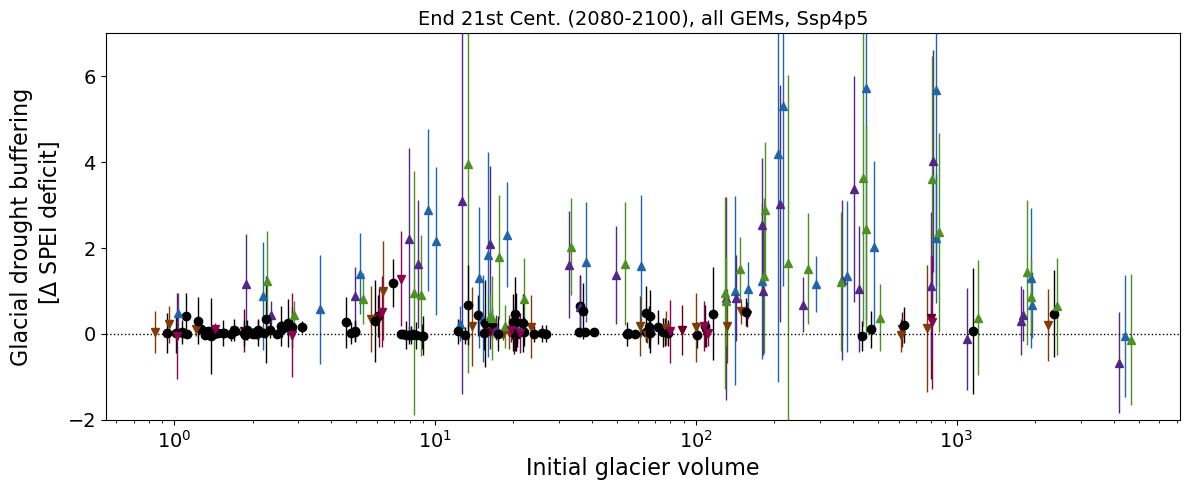

In [14]:
## Composite of stats over time
# color_fam = cm.get_cmap('tab20b')
# inc_color=color_fam(5)
# dec_color=color_fam(17)

## Color defaults per model
colorcode = ['RdBu', 'PuOr', 'PiYG']

## Create figure with only the end-century severity panel
fig, ax = plt.subplots(figsize=(12,5))

for increment in range(len(gmodels)):
    test_GEM = gmodels[increment]
    c = colorcode[increment]
    offset = increment*0.2
# for test_GEM, c in zip(gmodels, colorcode):
    this_cmap = plt.get_cmap(c)
    base_color = this_cmap(0.5)
    dec_color = this_cmap(-0.7)
    inc_color = this_cmap(0.9)
        
    for j, b in enumerate(basin_names):
        number_b = []
        severity_b = []
        number_midC = []
        number_endC = []
        severity_midC = []
        severity_endC = []
        
        vol = initial_vols.loc[b,test_GEM]

        for m in modelnames:
            number_b.append(basin_stats_bymodel_early[test_GEM][m][b][0][1]
                            -basin_stats_bymodel_early[test_GEM][m][b][0][0])
            number_midC.append(basin_stats_bymodel_midC[test_GEM][m][b][0][1]
                               -basin_stats_bymodel_midC[test_GEM][m][b][0][0])
            number_endC.append(basin_stats_bymodel_endC[test_GEM][m][b][0][1]
                               -basin_stats_bymodel_endC[test_GEM][m][b][0][0])
            severity_b.append(-1*(basin_stats_bymodel_early[test_GEM][m][b][2][1]
                                  -basin_stats_bymodel_early[test_GEM][m][b][2][0]))
            severity_midC.append(-1*(basin_stats_bymodel_midC[test_GEM][m][b][2][1]
                                     -basin_stats_bymodel_midC[test_GEM][m][b][2][0]))
            severity_endC.append(-1*(basin_stats_bymodel_endC[test_GEM][m][b][2][1]
                                     -basin_stats_bymodel_endC[test_GEM][m][b][2][0]))

        # ## Count pos vs neg buffering
        # if np.nanmean(number_b)>0:
        #     count_pbuff_num +=1
        # elif np.nanmean(number_b)<0:
        #     count_nbuff_num +=1
        # if np.nanmean(severity_b)>0:
        #     count_pbuff_sev +=1
        # elif np.nanmean(severity_b)<0:
        #     count_nbuff_sev +=1

        ## Color code changes over time
        # midC_v_hist_n = np.nanmean(number_midC)-np.nanmean(number_b)
        # if midC_v_hist_n >0.1: # buffering on number increasing
        #     midC_color_n=inc_color
        #     midC_marker_n='^'
        # elif midC_v_hist_n<-0.1:
        #     midC_color_n=dec_color
        #     midC_marker_n='v'
        # else:
        #     midC_color_n='k'
        #     midC_marker_n='o'
        # endC_v_hist_n = np.nanmean(number_endC)-np.nanmean(number_b)
        # if endC_v_hist_n >0.1:
        #     endC_color_n=inc_color
        #     endC_marker_n='^'
        # elif endC_v_hist_n<-0.1:
        #     endC_color_n=dec_color
        #     endC_marker_n='v'
        # else:
        #     endC_color_n='k'
        #     endC_marker_n='o'

        endC_v_hist_s = np.nanmean(severity_endC)-np.nanmean(severity_b)
        if endC_v_hist_s >0.1:
            endC_color_s=inc_color
            endC_marker_s='^'
        elif endC_v_hist_s<-0.1:
            endC_color_s=dec_color
            endC_marker_s='v'
        else:
            endC_color_s='k'
            endC_marker_s='o'
        # ## First column: historical
        # ax1.errorbar(pg, np.nanmean(number_b), 
        #              yerr=((np.nanmean(number_b)-np.nanmin(number_b), np.nanmax(number_b)-np.nanmean(number_b)),), 
        #              color='k', marker='o', lw=1.0)
        # ax7.errorbar(pg, np.nanmean(severity_b), 
        #              yerr=(((np.nanmean(severity_b)-np.nanmin(severity_b), np.nanmax(severity_b)-np.nanmean(severity_b)),)), 
        #              color='k', marker='o', lw=1.0)
        # ## Second column: mid-c
        # ax2.errorbar(pg, np.nanmean(number_midC), 
        #              yerr=(((np.nanmean(number_midC)-np.nanmin(number_midC), np.nanmax(number_midC)-np.nanmean(number_midC)),)), 
        #              color=midC_color_n, marker=midC_marker_n, lw=1.0)
        # ax8.errorbar(pg, np.nanmean(severity_midC), 
        #              yerr=(((np.nanmean(severity_midC)-np.nanmin(severity_midC), np.nanmax(severity_midC)-np.nanmean(severity_midC)),)), 
        #              color=midC_color_s, marker=midC_marker_s, lw=1.0)
        # ## Third column: end of century
        # ax3.errorbar(pg, np.nanmean(number_endC), 
        #              yerr=(((np.nanmean(number_endC)-np.nanmin(number_endC), np.nanmax(number_endC)-np.nanmean(number_endC)),)), 
        #              color=endC_color_n, marker=endC_marker_n, lw=1.0)
        ax.errorbar(vol, np.nanmean(severity_endC), 
                     yerr=np.asarray(np.nanmean(severity_endC)-np.nanmin(severity_endC), np.nanmax(severity_endC)-np.nanmean(severity_endC)).transpose(), 
                     color=endC_color_s, marker=endC_marker_s, lw=1.0)


ax.set_ylabel(r'Glacial drought buffering'
              '\n'
              ' [$\Delta$ SPEI deficit]',fontsize=16) 
ax.set(xscale='log', ylim=(-2,7))
ax.set_yticks([-2, 0, 2, 4, 6])
ax.set_xlabel('Initial glacier volume', fontsize=16)
ax.set_title('End 21st Cent. (2080-2100), all GEMs, {}'.format(scen), fontsize=14)
ax.tick_params(which='both', labelsize=14)
ax.axhline(0, ls=':', lw=1.0, color='k')
plt.tight_layout()

Read in percent glacier cover from Finn's summary stats.  Yay! Using just GloGEM baseline for now; these shouldn't vary much by GEM anyway.

In [15]:
## bring in Finn's basin summary stats
## this is for GloGEM for SSP245 for now
summary_file = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/Summary-statistics/MASTER_GloGEM.csv'

percent_glaciated = pd.read_csv(summary_file, index_col=0).loc[:, 'GlacierAreaFrac'] ## Lolol just read this in instead of fixing up the copypasta below

In [16]:
percent_glaciated.loc['YUKON']

0.0120027953168836

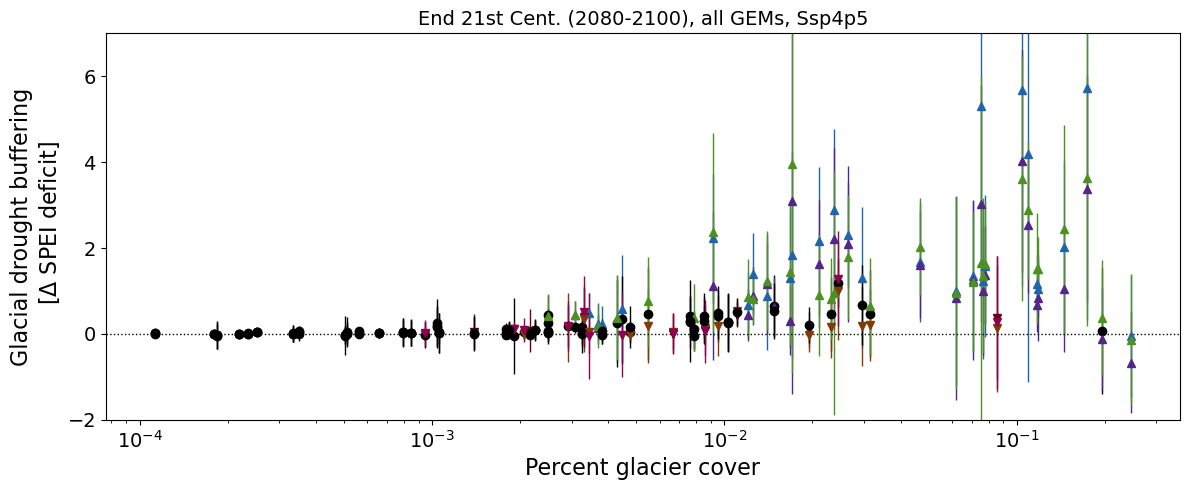

In [17]:
## Buffering vs percent glacier cover

## Color defaults per model
colorcode = ['RdBu', 'PuOr', 'PiYG']

## Create figure with only the end-century severity panel
fig, ax = plt.subplots(figsize=(12,5))

for increment in range(len(gmodels)):
    test_GEM = gmodels[increment]
    c = colorcode[increment]
    offset = increment*0.2
# for test_GEM, c in zip(gmodels, colorcode):
    this_cmap = plt.get_cmap(c)
    base_color = this_cmap(0.5)
    dec_color = this_cmap(-0.7)
    inc_color = this_cmap(0.9)
        
    for j, b in enumerate(basin_names):
        number_b = []
        severity_b = []
        number_midC = []
        number_endC = []
        severity_midC = []
        severity_endC = []
        
        # vol = initial_vols.loc[b,test_GEM]
        pc_glac = percent_glaciated.loc[b]

        for m in modelnames:
            number_b.append(basin_stats_bymodel_early[test_GEM][m][b][0][1]
                            -basin_stats_bymodel_early[test_GEM][m][b][0][0])
            number_midC.append(basin_stats_bymodel_midC[test_GEM][m][b][0][1]
                               -basin_stats_bymodel_midC[test_GEM][m][b][0][0])
            number_endC.append(basin_stats_bymodel_endC[test_GEM][m][b][0][1]
                               -basin_stats_bymodel_endC[test_GEM][m][b][0][0])
            severity_b.append(-1*(basin_stats_bymodel_early[test_GEM][m][b][2][1]
                                  -basin_stats_bymodel_early[test_GEM][m][b][2][0]))
            severity_midC.append(-1*(basin_stats_bymodel_midC[test_GEM][m][b][2][1]
                                     -basin_stats_bymodel_midC[test_GEM][m][b][2][0]))
            severity_endC.append(-1*(basin_stats_bymodel_endC[test_GEM][m][b][2][1]
                                     -basin_stats_bymodel_endC[test_GEM][m][b][2][0]))

    

        endC_v_hist_s = np.nanmean(severity_endC)-np.nanmean(severity_b)
        if endC_v_hist_s >0.1:
            endC_color_s=inc_color
            endC_marker_s='^'
        elif endC_v_hist_s<-0.1:
            endC_color_s=dec_color
            endC_marker_s='v'
        else:
            endC_color_s='k'
            endC_marker_s='o'
        # 
        ax.errorbar(pc_glac, np.nanmean(severity_endC), 
                     yerr=np.asarray(np.nanmean(severity_endC)-np.nanmin(severity_endC), np.nanmax(severity_endC)-np.nanmean(severity_endC)).transpose(), 
                     color=endC_color_s, marker=endC_marker_s, lw=1.0)


ax.set_ylabel(r'Glacial drought buffering'
              '\n'
              ' [$\Delta$ SPEI deficit]',fontsize=16) 
ax.set(xscale='log', ylim=(-2,7))
ax.set_yticks([-2, 0, 2, 4, 6])
ax.set_xlabel('Percent glacier cover', fontsize=16)
ax.set_title('End 21st Cent. (2080-2100), all GEMs, {}'.format(scen), fontsize=14)
ax.tick_params(which='both', labelsize=14)
ax.axhline(0, ls=':', lw=1.0, color='k')
plt.tight_layout()

This returns the expected relationship between buffering and initial glacier cover.  
TODO: eventually compute Spearman's rho over full scatter to compare with single-GEM results reported before

## Plot against aridity index

We need to compute the aridity index from historical precipitation and PET.  This data is now updated for the CMIP6 model realizations and list of 75 basins. Plot with these.

In [18]:
# ## 2022, CMIP5, GloGEM-only version of these variables
# modelnames_22 = ['CanESM2', 'CCSM4', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GISS-E2-R', 'INMCM4', 'MIROC-ESM', 'NorESM1-M'] # all models used in comparison
# scenarios_22 = ['Rcp4p5', 'Rcp8p5'] # climate scenarios
# ## Basins in the order they are written
# basin_names_22 = ['INDUS','TARIM','BRAHMAPUTRA','ARAL SEA','COPPER','GANGES','YUKON','ALSEK','SUSITNA','BALKHASH','STIKINE','SANTA CRUZ',
# 'FRASER','BAKER','YANGTZE','SALWEEN','COLUMBIA','ISSYK-KUL','AMAZON','COLORADO','TAKU','MACKENZIE','NASS','THJORSA','JOEKULSA A F.',
# 'KUSKOKWIM','RHONE','SKEENA','OB','OELFUSA','MEKONG','DANUBE','NELSON RIVER','PO','KAMCHATKA','RHINE','GLOMA','HUANG HE','INDIGIRKA',
# 'LULE','RAPEL','SANTA','SKAGIT','KUBAN','TITICACA','NUSHAGAK','BIOBIO','IRRAWADDY','NEGRO','MAJES','CLUTHA','DAULE-VINCES',
# 'KALIXAELVEN','MAGDALENA','DRAMSELV','COLVILLE']

fpath_p_pet = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/GCM-PET_Precip/'
## Settings in filenames -- slightly different model names and scenarios
modelnames = ['BCC-CSM2-MR',
              'MPI-ESM1-2-HR',
              'MRI-ESM2-0',
              'CESM2-WACCM',
              'NorESM2-MM',
              'FGOALS-f3-L',
              'GFDL-ESM4',
              'INM-CM4-8',
              'INM-CM5-0',
              'EC-Earth3',
              'EC-Earth3-Veg']
# scenarios = ['Ssp2p6', 'Ssp4p5', 'Ssp7p0', 'Ssp8p5'] # climate scenarios
scenarios = ['Ssp4p5', 'Ssp8p5'] # climate scenarios included for 11 GCM set


yrs = np.linspace(1900, 2101, num=2412) # time interval over which we have data

PET_by_model = {m: {} for m in modelnames}
P_by_model = {m: {} for m in modelnames}
for m in modelnames:
    for s in scenarios:
        example_pet = fpath_p_pet+'{}_PET_{}.txt'.format(m,s)
        example_p = fpath_p_pet+'{}_PREC_{}.txt'.format(m,s)
        PET_by_model[m][s] = np.loadtxt(example_pet)
        P_by_model[m][s] = np.loadtxt(example_p)
    
    
PET_by_basin = {b: {} for b in basin_names} # potential evapotranspiration by basin
P_by_basin = {b: {} for b in basin_names} # precipitation by basin
AI_by_basin = {b: {} for b in basin_names} # AI by basin
historical_avg_AI = [] # list for multi-model average basin aridity index over historical period
avg_precip = []
for i, b in enumerate(basin_names):
    PET_by_basin[b] = {s: {} for s in scenarios}
    P_by_basin[b] = {s: {} for s in scenarios}
    AI_by_basin[b] = {s: {} for s in scenarios}
    for s in scenarios:
        tempdict_pet = {}
        tempdict_p = {}
        tempdict_ai = {}
        for m in modelnames:
            tempdict_pet[m] = PET_by_model[m][s][i] 
            tempdict_p[m] = P_by_model[m][s][i]
            tempdict_ai[m] = np.nanmedian(tempdict_p[m][0:959])/np.nanmedian(tempdict_pet[m][0:959]) # historical avg(P)/avg(PET) for this model
            if tempdict_ai[m]<0:
                # tempdict_ai[m] = np.nan
                tempdict_ai[m] = np.abs(tempdict_ai[m])
        PET_by_basin[b][s] = pd.DataFrame.from_dict(tempdict_pet)
        P_by_basin[b][s] = pd.DataFrame.from_dict(tempdict_p)
        AI_by_basin[b][s] = np.nanmedian([tempdict_ai[m] for m in modelnames])
    historical_avg_AI.append(AI_by_basin[b]['Ssp4p5'])
    avg_precip.append(np.nanmean(P_by_basin[b]['Ssp4p5']))

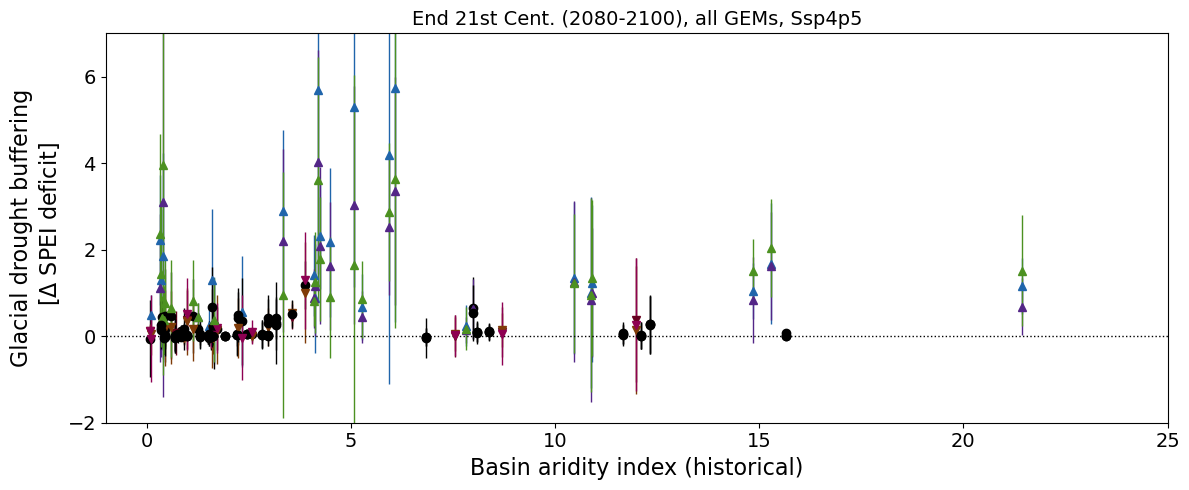

In [19]:
## Composite of stats over time
# color_fam = cm.get_cmap('tab20b')
# inc_color=color_fam(5)
# dec_color=color_fam(17)

## Color defaults per model
colorcode = ['RdBu', 'PuOr', 'PiYG']

## Create figure with only the end-century severity panel
fig, ax = plt.subplots(figsize=(12,5))

for increment in range(len(gmodels)):
    test_GEM = gmodels[increment]
    c = colorcode[increment]
    offset = increment*0.2
# for test_GEM, c in zip(gmodels, colorcode):
    this_cmap = plt.get_cmap(c)
    base_color = this_cmap(0.5)
    dec_color = this_cmap(-0.7)
    inc_color = this_cmap(0.9)
        
    for j,bname in enumerate(basin_names):
        ## correcting small discrepancies between basin name sets
        if bname=='TARIM':
            b='TARIM HE'
        elif bname=='BALKHASH':
            b='LAKE BALKHASH'
        elif bname=='ISSYK-KUL':
            b='YSYK-KOL'
        elif bname=='JOEKULSA A F.':
            b='JOKULSA A FJOLLUM'
        elif bname=='OELFUSA':
            b='OLFUSA'
        elif bname=='NELSON RIVER':
            b='NELSON'
        elif bname=='GLOMA':
            b='GLOMAA'
        elif bname=='HUANG HE':
            b='YELLOW RIVER'
        elif bname=='LULE':
            b='LULEALVEN'
        elif bname=='DAULE-VINCES':
            continue ## not included in 2024 set, as far as I can tell
        elif bname=='KALIXAELVEN':
            b='KALIXALVEN'
        elif bname=='DRAMSELV':
            b='DRAMSELVA'
        else:
            b=bname
        number_b = []
        severity_b = []
        number_midC = []
        number_endC = []
        severity_midC = []
        severity_endC = []
        
        hist_AI = historical_avg_AI[j]

        for m in modelnames:
            number_b.append(basin_stats_bymodel_early[test_GEM][m][b][0][1]
                            -basin_stats_bymodel_early[test_GEM][m][b][0][0])
            number_midC.append(basin_stats_bymodel_midC[test_GEM][m][b][0][1]
                               -basin_stats_bymodel_midC[test_GEM][m][b][0][0])
            number_endC.append(basin_stats_bymodel_endC[test_GEM][m][b][0][1]
                               -basin_stats_bymodel_endC[test_GEM][m][b][0][0])
            severity_b.append(-1*(basin_stats_bymodel_early[test_GEM][m][b][2][1]
                                  -basin_stats_bymodel_early[test_GEM][m][b][2][0]))
            severity_midC.append(-1*(basin_stats_bymodel_midC[test_GEM][m][b][2][1]
                                     -basin_stats_bymodel_midC[test_GEM][m][b][2][0]))
            severity_endC.append(-1*(basin_stats_bymodel_endC[test_GEM][m][b][2][1]
                                     -basin_stats_bymodel_endC[test_GEM][m][b][2][0]))

        endC_v_hist_s = np.nanmean(severity_endC)-np.nanmean(severity_b)
        if endC_v_hist_s >0.1:
            endC_color_s=inc_color
            endC_marker_s='^'
        elif endC_v_hist_s<-0.1:
            endC_color_s=dec_color
            endC_marker_s='v'
        else:
            endC_color_s='k'
            endC_marker_s='o'

        ax.errorbar(hist_AI, np.nanmean(severity_endC), 
                     yerr=np.asarray(np.nanmean(severity_endC)-np.nanmin(severity_endC), np.nanmax(severity_endC)-np.nanmean(severity_endC)).transpose(), 
                     color=endC_color_s, marker=endC_marker_s, lw=1.0)


ax.set_ylabel(r'Glacial drought buffering'
              '\n'
              ' [$\Delta$ SPEI deficit]',fontsize=16) 
ax.set(
    # xscale='log', ,
    xlim=(-1,25),
    ylim=(-2,7))
ax.set_yticks([-2, 0, 2, 4, 6])
ax.set_xlabel('Basin aridity index (historical)', fontsize=16)
ax.set_title('End 21st Cent. (2080-2100), all GEMs, {}'.format(scen), fontsize=14)
ax.tick_params(which='both', labelsize=14)
ax.axhline(0, ls=':', lw=1.0, color='k')
plt.tight_layout()

### Statistical metrics
We previously reported Spearman's $\rho$ for the strength of the relationship between basin variables (percent glaciation or aridity index) and drought buffering effect.  Let's compute that for these multi-GEM, CMIP6 results.

In [ ]:
## pasted from previous work (2021)
## TODO: flatten the number and severity stats from per-GEM into aggregate

## Compute Spearman's corrs with other variables for comparison
constructor_d = {}
for f,name in zip((percent_glaciated, BasinArea, avg_precip, historical_avg_AI), 
             ('percent_glac', 'BasinArea', 'avg_precip', 'historical_avg_AI')):
    if sum(np.isnan(f))>0:
        print('Warning: NaNs identified in field {}'.format(name))
        fn = np.asarray(f)[~np.isnan(f)] # there is a single NaN in AI
        mean_number_b = np.asarray(mean_number_b)[~np.isnan(f)]
        mean_severity_b = np.asarray(mean_severity_b)[~np.isnan(f)]
        mean_number_midC = np.asarray(mean_number_midC)[~np.isnan(f)]
        mean_severity_midC = np.asarray(mean_severity_midC)[~np.isnan(f)]
        mean_number_endC = np.asarray(mean_number_endC)[~np.isnan(f)]
        mean_severity_endC = np.asarray(mean_severity_endC)[~np.isnan(f)]
    else: 
        fn = f
        
    d = {'Number-hist': stats.spearmanr(fn, mean_number_b), 
         'Severity-hist': stats.spearmanr(fn, mean_severity_b), 
         'Number-midC': stats.spearmanr(fn, mean_number_midC), 
         'Severity-midC': stats.spearmanr(fn, mean_severity_midC), 
         'Number-endC': stats.spearmanr(fn, mean_number_endC), 
         'Severity-endC': stats.spearmanr(fn, mean_severity_endC)}
    constructor_d[name] = d
df = pd.DataFrame.from_dict(constructor_d)
